# SIR Traffic Congestion Analysis

# Content Table

- [Imports](#Imports)
- [Data Preprocessing](#Data-Preprocessing)
- [Section Plots](#Section-Plots)
- [Flow-Capacity Ratio](#Flow-Capacity-Ratio)
- [Percentage of Congested Links](#Percentage-of-Congested-Links)
- [CSV Processing](#CSV-Processing)
- [SIR Model](#SIR-Model)

## Imports

In [27]:
import sqlite3
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import contextily as cx
from copy import deepcopy

## Data Preprocessing

In [28]:
# GLOBAL VARIABLES/CONSTANTS

# SQLite File Path formatter
__SQLITE_PATH_FORMAT = "Data/carl_10_18_18_saberi/Dynamel_06_09_2018_rpl_{number}.sqlite" 

# CSV Path
__CSV_PATH_FORMAT = "Data/trafficspreading/Simulation_{hour}h_{percent}.csv"
__CSV_HOUR = [1, 4]
__CSV_1_PERCENT = [75, 100, 120, 150, 175, 200]
__CSV_4_PERCENT = [100, 120, 150, 175, 200]

# sections.shp File Path
__SECTION_SHP = "Data/carl_10_18_18_saberi/sections.shp"

# Number of experiments
__NUM_EXP = 3

# SQL Query to be excecuted for MISECT table
__SQL_EXTRACT_QUERY = 'SELECT * FROM MESECT'

# Columns to extract from MISECT table
__SQL_COLUMNS = ['ent', 'eid', 'flow_capacity', 'ttime', 'speed', 'travel', 'traveltime']

In [29]:
# Create a SQL connection to our SQLite database

# A list of established connections to our databases
con = []

for i in range(__NUM_EXP):
    con.append(sqlite3.connect(__SQLITE_PATH_FORMAT.format(number=i+1)))

In [30]:
# Run SQL query and convert SQL to DataFrame

# List of the sql queries
sql_queries = []

# List of dataframes extracted from each experiment
df = []
for i in range(__NUM_EXP):
    # Run SQL
    query = pd.read_sql(__SQL_EXTRACT_QUERY, con[i])
    sql_queries.append(query)
    
    # Convert SQL to DataFrame
    dataframe = pd.DataFrame(query, columns = __SQL_COLUMNS)
    df.append(dataframe)

In [31]:
# Read the sections.shp shapefile
sections = gpd.read_file(__SECTION_SHP)
sections.crs

<Derived Projected CRS: EPSG:32755>
Name: WGS 84 / UTM zone 55S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 144°E and 150°E, southern hemisphere between 80°S and equator, onshore and offshore. Australia. Papua New Guinea.
- bounds: (144.0, -80.0, 150.0, 0.0)
Coordinate Operation:
- name: UTM zone 55S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [32]:
# Create a deep copy of df as back up in order not to rerun the above cell
df_copy = copy.deepcopy(df)
sections_copy = copy.deepcopy(sections)

In [33]:
sections.head()

,id,eid,name,nb_lanes,speed,capacity,rd_type,func_class,fnode,tnode,geometry
0,329.0,7001_7008,None,2,90.0,1700.0,190254.0,2,58250.0,58251.0,"LINESTRING (325310.976 5803351.242, 325835.597..."
1,330.0,7001_7045,None,1,50.0,1000.0,46.0,3,58250.0,58252.0,"LINESTRING (325304.754 5803342.331, 325265.550..."
2,331.0,7001_30365,None,2,90.0,1700.0,190254.0,2,58250.0,58253.0,"LINESTRING (325297.037 5803347.267, 325237.033..."
3,332.0,7002_7005,None,3,90.0,2700.0,190256.0,2,58254.0,58255.0,"LINESTRING (337994.423 5803343.369, 338346.758..."
4,333.0,7002_7013,None,2,100.0,20000.0,190265.0,4,58254.0,58256.0,"LINESTRING (337982.142 5803330.349, 337968.061..."


In [34]:
sections.shape

(34918, 11)

## Section Plots

Text(0.5, 1.0, 'Road Sections')

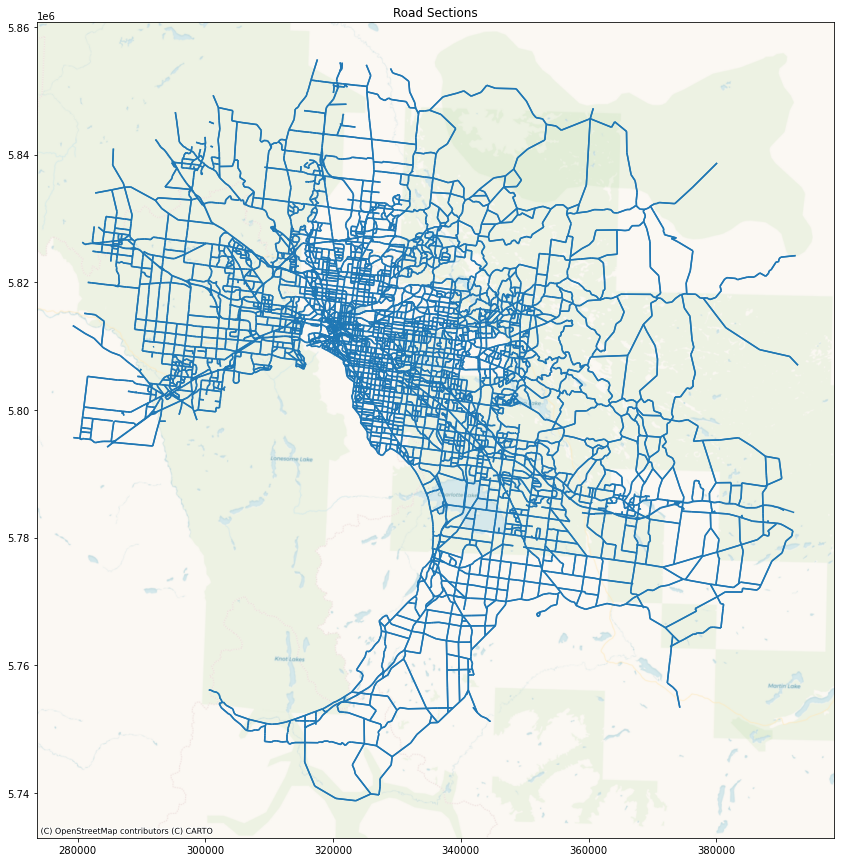

In [35]:
ax = sections.plot(figsize=(15, 15))
cx.add_basemap(ax, crs='EPSG:32610', source=cx.providers.CartoDB.Voyager) #4326
plt.title('Road Sections')

In [36]:
df[0]['ent'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,  0])

In [37]:
df[0].head()

,ent,eid,flow_capacity,ttime,speed,travel,traveltime
0,1,7001_7008,0.058824,22.545500,88.820888,13.212775,563.637505
1,1,7001_7045,0.008000,20.960485,55.789077,0.649645,41.920969
2,1,7001_30365,0.263529,9.496183,53.963947,6.826232,1063.572470
3,1,7002_7005,0.094815,22.385627,69.802622,22.706630,1432.680118
4,1,7002_7013,0.057000,12.766555,68.209012,20.708987,3638.468262


## Flow-Capacity Ratio

In [38]:
# Merge datasets: sections and dataframe

group_cols = ['ent', 'eid']
# identify the columns which we want to average; this could
# equivalently be defined as list(df.columns[4:])
metric_cols = ['flow_capacity']

# create a new DataFrame with a MultiIndex consisting of the group_cols
# and a column for the mean of each column in metric_cols
aggs = df[0].groupby(group_cols)[metric_cols].mean()
# remove the metric_cols from df because we are going to replace them
# with the means in aggs
df0_x = df[0].copy()

df0_x.drop(metric_cols, axis=1, inplace=True)
# dedupe to leave only one row with each combination of group_cols
# in df
df0_x.drop_duplicates(subset=group_cols, keep='last', inplace=True)
# add the mean columns from aggs into df
df0_ave= df0_x.merge(right=aggs, right_index=True, left_on=group_cols, how='right')

df0_ave.head()

,ent,eid,ttime,speed,travel,traveltime,flow_capacity
1159240,0,10000_10001,14.300521,55.009973,19.989633,1315.647966,0.0230
1159241,0,10000_10003,364.409673,21.110411,392.309548,360765.576476,0.2475
1159243,0,10001_10000,183.759638,26.473660,215.105837,181922.042064,0.2475
1159242,0,10001_9999,30.006479,54.995151,41.931214,2760.596043,0.0230
1159244,0,10002_10003,165.698011,32.442295,212.528067,170503.253437,0.3675


In [39]:
sections_m0 = pd.merge(df0_ave, sections, how='left', left_on='eid', right_on='eid')
sections_m0

,ent,eid,ttime,speed_x,travel,traveltime,flow_capacity,id,name,nb_lanes,speed_y,capacity,rd_type,func_class,fnode,tnode,geometry
0,0,10000_10001,14.300521,55.009973,19.989633,1315.647966,0.0230,7580.0,None,1,50.0,1000.0,190262.0,3,63407.0,10000718.0,"LINESTRING (346022.985 5815794.565, 345805.985..."
1,0,10000_10003,364.409673,21.110411,392.309548,360765.576476,0.2475,7581.0,None,1,50.0,1000.0,190262.0,3,63407.0,63408.0,"LINESTRING (346024.424 5815795.436, 345858.803..."
2,0,10001_10000,183.759638,26.473660,215.105837,181922.042064,0.2475,7583.0,None,1,50.0,1000.0,190262.0,3,10000717.0,63407.0,"LINESTRING (345806.137 5815808.561, 346023.137..."
3,0,10001_9999,30.006479,54.995151,41.931214,2760.596043,0.0230,7582.0,None,1,50.0,1000.0,190262.0,3,10000718.0,63405.0,"LINESTRING (345804.590 5815807.356, 345893.590..."
4,0,10002_10003,165.698011,32.442295,212.528067,170503.253437,0.3675,7584.0,None,1,50.0,700.0,190259.0,3,63409.0,63408.0,"LINESTRING (345647.498 5815456.215, 345852.934..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593567,16,9997_9998,3425.677139,0.332488,10.872733,140452.762710,0.1640,7575.0,None,1,50.0,1000.0,190262.0,3,10000715.0,63402.0,"LINESTRING (347587.254 5816618.551, 347850.254..."
593568,16,9998_9996,2357.285162,4.517715,10.462708,106077.832294,0.1800,7576.0,None,1,50.0,1000.0,190262.0,3,63402.0,63401.0,"LINESTRING (347851.410 5816583.719, 347953.081..."
593569,16,9998_9997,18.922852,50.628358,16.441694,1173.216826,0.2480,7577.0,None,1,50.0,1000.0,190262.0,3,63402.0,10000716.0,"LINESTRING (347849.869 5816581.576, 347586.869..."
593570,16,9999_10001,29.215190,56.633766,6.836611,438.227848,0.0600,7578.0,None,1,50.0,1000.0,190262.0,3,63405.0,10000717.0,"LINESTRING (345896.532 5816253.770, 345807.532..."


In [40]:
# convert to GeoDataframe

gdf0 = gpd.GeoDataFrame(sections_m0, geometry='geometry')
gdf0['flow_capacity'] = gdf0['flow_capacity'].fillna(0)
gdf0.dropna()
gdf0.head()

,ent,eid,ttime,speed_x,travel,traveltime,flow_capacity,id,name,nb_lanes,speed_y,capacity,rd_type,func_class,fnode,tnode,geometry
0,0,10000_10001,14.300521,55.009973,19.989633,1315.647966,0.0230,7580.0,None,1,50.0,1000.0,190262.0,3,63407.0,10000718.0,"LINESTRING (346022.985 5815794.565, 345805.985..."
1,0,10000_10003,364.409673,21.110411,392.309548,360765.576476,0.2475,7581.0,None,1,50.0,1000.0,190262.0,3,63407.0,63408.0,"LINESTRING (346024.424 5815795.436, 345858.803..."
2,0,10001_10000,183.759638,26.473660,215.105837,181922.042064,0.2475,7583.0,None,1,50.0,1000.0,190262.0,3,10000717.0,63407.0,"LINESTRING (345806.137 5815808.561, 346023.137..."
3,0,10001_9999,30.006479,54.995151,41.931214,2760.596043,0.0230,7582.0,None,1,50.0,1000.0,190262.0,3,10000718.0,63405.0,"LINESTRING (345804.590 5815807.356, 345893.590..."
4,0,10002_10003,165.698011,32.442295,212.528067,170503.253437,0.3675,7584.0,None,1,50.0,700.0,190259.0,3,63409.0,63408.0,"LINESTRING (345647.498 5815456.215, 345852.934..."


Text(0.5, 1.0, 'Melbourne')

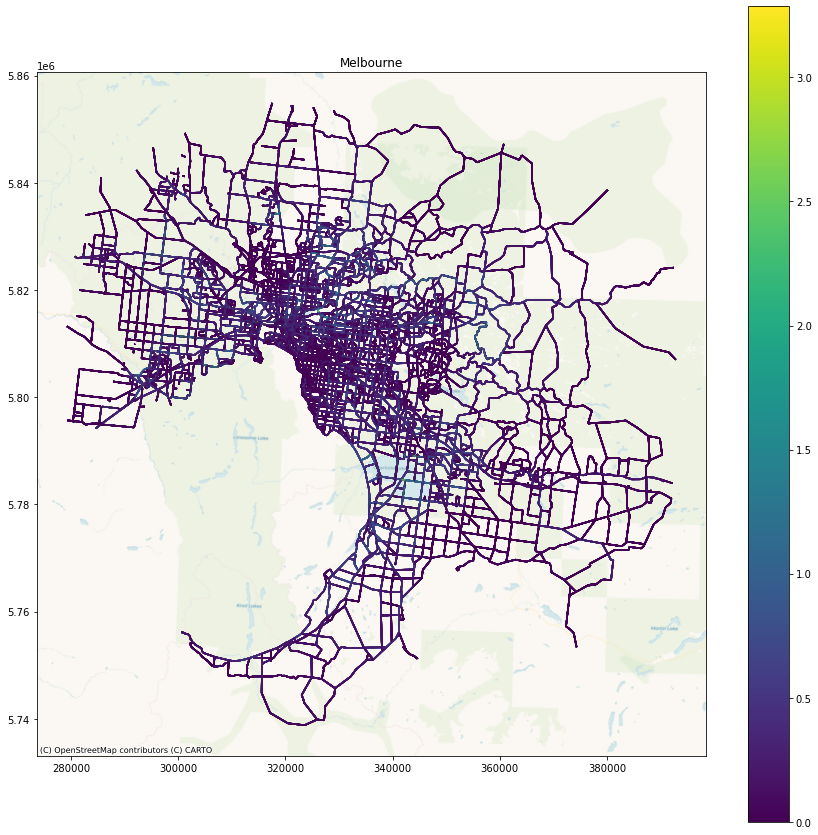

In [41]:
ax = gdf0.plot(figsize=(15, 15), alpha=0.5, column='flow_capacity', legend=True)
cx.add_basemap(ax, crs='EPSG:32610', source=cx.providers.CartoDB.Voyager) #4326
plt.title('Melbourne')

In [42]:
# Preprocess dataframe to merge with sections

group_cols = ['ent','eid']
# identify the columns which we want to average; this could
# equivalently be defined as list(df.columns[4:])
metric_cols = ['flow_capacity']

# create a new DataFrame with a MultiIndex consisting of the group_cols
# and a column for the mean of each column in metric_cols
aggs = []
for i in range(__NUM_EXP):
    aggs.append(df[i].groupby(group_cols)[metric_cols].mean())

# 1. remove the metric_cols from df because we are going to replace them
# with the means in aggs 
# 2. dedupe to leave only one row with each combination of group_cols
# in df
for i in range(__NUM_EXP):
    # Step 1
    df[i].drop(metric_cols, axis=1, inplace=True)
    
    # Step 2
    df[i].drop_duplicates(subset=group_cols, keep='last', inplace=True)

# add the mean columns from aggs into df
for i in range(__NUM_EXP):
    df[i] = df[i].merge(right=aggs[i], right_index=True, left_on=group_cols, how='right')

In [43]:
# Merge datasets: sections and dataframe
sections_m = []

for i in range(__NUM_EXP):
    sections_m.append(pd.merge(df[i], sections, how='left', left_on='eid', right_on='eid'))

In [44]:
# Convert the merged sections into GeoDataFrame and replace null values with 0
gdf = []

for i in range(__NUM_EXP):
    gdf.append(gpd.GeoDataFrame(sections_m[i], geometry='geometry'))
    gdf[i]['flow_capacity'] = gdf[i]['flow_capacity'].fillna(0)

In [45]:
# Group each GeoDataFrame on timestep and aggregate by mean
# Remove the first row as it is the average of the rest
gdf_agg = []

for i in range(__NUM_EXP):
    gdf_agg.append(gdf[i].groupby('ent').agg(np.mean).iloc[1:, :])

In [46]:
def plot_experiment(gdf_list, col_name):
    """
    Plot all the curves of the data for a list of GeoDataFrames on the designated column.
    
    Keyword arguments:
    gdf_list --- a list of GeoDataFrame that contains the processed data 
                 merged from sections.shp and sqlite output from aimsun
    col_name --- the name of the column to be plotted
    """ 
    for i in range(len(gdf_list)):
        plt.plot(np.array(gdf_list[i][col_name]))

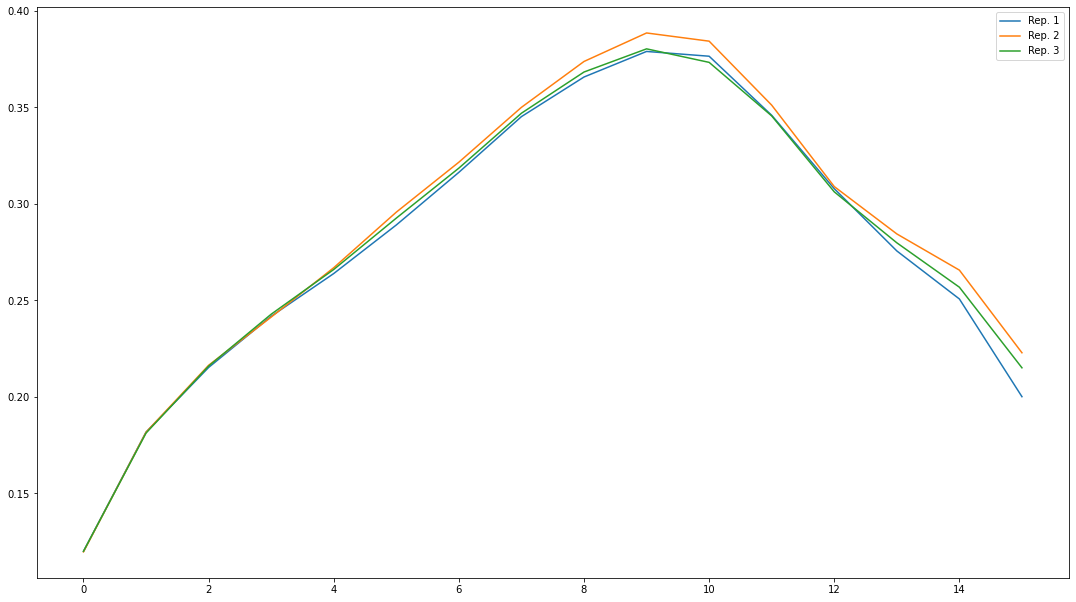

In [47]:
# Plot the aggregated(mean) flow-capacity ratio at each timestep for each experiment
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plot_experiment(gdf_agg, 'flow_capacity')
plt.legend(["Rep. 1",
            "Rep. 2",
            "Rep. 3"
           ])
plt.show()

## Percentage of Congested Links:

In [48]:
# Restore the sections file in case of modification
sections = copy.deepcopy(sections_copy)
sections = sections.rename(columns={'speed': 'speed_limit'})

In [49]:
sections.head()

,id,eid,name,nb_lanes,speed_limit,capacity,rd_type,func_class,fnode,tnode,geometry
0,329.0,7001_7008,None,2,90.0,1700.0,190254.0,2,58250.0,58251.0,"LINESTRING (325310.976 5803351.242, 325835.597..."
1,330.0,7001_7045,None,1,50.0,1000.0,46.0,3,58250.0,58252.0,"LINESTRING (325304.754 5803342.331, 325265.550..."
2,331.0,7001_30365,None,2,90.0,1700.0,190254.0,2,58250.0,58253.0,"LINESTRING (325297.037 5803347.267, 325237.033..."
3,332.0,7002_7005,None,3,90.0,2700.0,190256.0,2,58254.0,58255.0,"LINESTRING (337994.423 5803343.369, 338346.758..."
4,333.0,7002_7013,None,2,100.0,20000.0,190265.0,4,58254.0,58256.0,"LINESTRING (337982.142 5803330.349, 337968.061..."


In [50]:
total_length = sections['geometry'].length.sum()
total_length

13509020.400606522

In [51]:
# Drop the sections with missing average speed
df = copy.deepcopy(df_copy)
for i in range(__NUM_EXP):
    df[i] = df[i][df[i]['speed'] > 0.0]

In [52]:
# Preprocess dataframe to merge with sections

group_cols = ['ent', 'eid']
# identify the columns which we want to average; this could
# equivalently be defined as list(df.columns[4:])
metric_cols = ['speed']

# create a new DataFrame with a MultiIndex consisting of the group_cols
# and a column for the mean of each column in metric_cols
aggs = []
for i in range(__NUM_EXP):
    aggs.append(df[i].groupby(group_cols)[metric_cols].mean())

# 1. remove the metric_cols from df because we are going to replace them
# with the means in aggs 
# 2. dedupe to leave only one row with each combination of group_cols
# in df
for i in range(__NUM_EXP):
    # Step 1
    df[i].drop(metric_cols, axis=1, inplace=True)
    
    # Step 2
    df[i].drop_duplicates(subset=group_cols, keep='last', inplace=True)

# add the mean columns from aggs into df
for i in range(__NUM_EXP):
    df[i] = df[i].merge(right=aggs[i], right_index=True, left_on=group_cols, how='right')

In [53]:
# Merge datasets: sections and dataframe
sections_cong = []

for i in range(__NUM_EXP):
    sections_cong.append(pd.merge(df[i], sections, how='left', left_on='eid', right_on='eid'))

In [54]:
sections_cong[0].head()

,ent,eid,flow_capacity,ttime,travel,traveltime,speed,id,name,nb_lanes,speed_limit,capacity,rd_type,func_class,fnode,tnode,geometry
0,0,10000_10001,0.0230,14.300521,19.989633,1315.647966,55.009973,7580.0,None,1,50.0,1000.0,190262.0,3,63407.0,10000718.0,"LINESTRING (346022.985 5815794.565, 345805.985..."
1,0,10000_10003,0.2475,364.409673,392.309548,360765.576476,21.110411,7581.0,None,1,50.0,1000.0,190262.0,3,63407.0,63408.0,"LINESTRING (346024.424 5815795.436, 345858.803..."
2,0,10001_10000,0.2475,183.759638,215.105837,181922.042064,26.473660,7583.0,None,1,50.0,1000.0,190262.0,3,10000717.0,63407.0,"LINESTRING (345806.137 5815808.561, 346023.137..."
3,0,10001_9999,0.0230,30.006479,41.931214,2760.596043,54.995151,7582.0,None,1,50.0,1000.0,190262.0,3,10000718.0,63405.0,"LINESTRING (345804.590 5815807.356, 345893.590..."
4,0,10002_10003,0.3675,165.698011,212.528067,170503.253437,32.442295,7584.0,None,1,50.0,700.0,190259.0,3,63409.0,63408.0,"LINESTRING (345647.498 5815456.215, 345852.934..."


In [55]:
for i in range(__NUM_EXP):
    sections_cong[i] = sections_cong[i][['ent', 'eid', 'speed', 'speed_limit', 'geometry']]

In [56]:
# Convert the merged sections into GeoDataFrame and drop null values
gdf = []

for i in range(__NUM_EXP):
    gdf.append(gpd.GeoDataFrame(sections_cong[i], geometry='geometry'))
    gdf[i]['speed'] = gdf[i]['speed'].dropna()
    gdf[i]['length'] = gdf[i]['geometry'].length

In [57]:
gdf[0].head()

,ent,eid,speed,speed_limit,geometry,length
0,0,10000_10001,55.009973,50.0,"LINESTRING (346022.985 5815794.565, 345805.985...",217.278623
1,0,10000_10003,21.110411,50.0,"LINESTRING (346024.424 5815795.436, 345858.803...",396.272271
2,0,10001_10000,26.473660,50.0,"LINESTRING (345806.137 5815808.561, 346023.137...",217.278623
3,0,10001_9999,54.995151,50.0,"LINESTRING (345804.590 5815807.356, 345893.590...",455.774067
4,0,10002_10003,32.442295,50.0,"LINESTRING (345647.498 5815456.215, 345852.934...",206.538452


In [58]:
gdf[0].shape

(535338, 6)

In [59]:
# Threshold for a section to be considered congested
rho = np.linspace(0.1, 0.9, 9)
rho

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [60]:
# Add a column for each section at each threshold,
# congested = 1, else 0
for threshold in rho:
    for i in range(__NUM_EXP):
        speed_ratio = gdf[i]['speed'] / gdf[i]['speed_limit']
        gdf[i]['congested at rho = ' + str(round(threshold, 1))] = [int(r < threshold) for r in speed_ratio]

In [61]:
gdf[0].head()

,ent,eid,speed,speed_limit,geometry,length,congested at rho = 0.1,congested at rho = 0.2,congested at rho = 0.3,congested at rho = 0.4,congested at rho = 0.5,congested at rho = 0.6,congested at rho = 0.7,congested at rho = 0.8,congested at rho = 0.9
0,0,10000_10001,55.009973,50.0,"LINESTRING (346022.985 5815794.565, 345805.985...",217.278623,0,0,0,0,0,0,0,0,0
1,0,10000_10003,21.110411,50.0,"LINESTRING (346024.424 5815795.436, 345858.803...",396.272271,0,0,0,0,1,1,1,1,1
2,0,10001_10000,26.473660,50.0,"LINESTRING (345806.137 5815808.561, 346023.137...",217.278623,0,0,0,0,0,1,1,1,1
3,0,10001_9999,54.995151,50.0,"LINESTRING (345804.590 5815807.356, 345893.590...",455.774067,0,0,0,0,0,0,0,0,0
4,0,10002_10003,32.442295,50.0,"LINESTRING (345647.498 5815456.215, 345852.934...",206.538452,0,0,0,0,0,0,1,1,1


In [62]:
# next steps: multiply the congested at rho column 
# with section length to create a congestion weight column
# that can be summed to get our desired result

In [63]:
# Add a column for congestion weight at each threshold,
# congested = 1, else 0
for threshold in rho:
    for i in range(__NUM_EXP):
        weight = gdf[i]['length'] * gdf[i]['congested at rho = ' + str(round(threshold, 1))]
        gdf[i]['weight at rho = ' + str(round(threshold, 1))] = weight

In [64]:
gdf[0].head()

,ent,eid,speed,speed_limit,geometry,length,congested at rho = 0.1,congested at rho = 0.2,congested at rho = 0.3,congested at rho = 0.4,...,congested at rho = 0.9,weight at rho = 0.1,weight at rho = 0.2,weight at rho = 0.3,weight at rho = 0.4,weight at rho = 0.5,weight at rho = 0.6,weight at rho = 0.7,weight at rho = 0.8,weight at rho = 0.9
0,0,10000_10001,55.009973,50.0,"LINESTRING (346022.985 5815794.565, 345805.985...",217.278623,0,0,0,0,...,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,10000_10003,21.110411,50.0,"LINESTRING (346024.424 5815795.436, 345858.803...",396.272271,0,0,0,0,...,1,0.0,0.0,0.0,0.0,396.272271,396.272271,396.272271,396.272271,396.272271
2,0,10001_10000,26.473660,50.0,"LINESTRING (345806.137 5815808.561, 346023.137...",217.278623,0,0,0,0,...,1,0.0,0.0,0.0,0.0,0.000000,217.278623,217.278623,217.278623,217.278623
3,0,10001_9999,54.995151,50.0,"LINESTRING (345804.590 5815807.356, 345893.590...",455.774067,0,0,0,0,...,0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,0,10002_10003,32.442295,50.0,"LINESTRING (345647.498 5815456.215, 345852.934...",206.538452,0,0,0,0,...,1,0.0,0.0,0.0,0.0,0.000000,0.000000,206.538452,206.538452,206.538452


In [65]:
# Group each GeoDataFrame on timestep and aggregate by sum
# Remove the first row as it is the average of the rest
gdf_agg = []

for i in range(__NUM_EXP):
    gdf_agg.append(gdf[i].groupby('ent').agg(np.sum).iloc[1:, :])

In [66]:
gdf_agg[0].head()

,speed,speed_limit,length,congested at rho = 0.1,congested at rho = 0.2,congested at rho = 0.3,congested at rho = 0.4,congested at rho = 0.5,congested at rho = 0.6,congested at rho = 0.7,...,congested at rho = 0.9,weight at rho = 0.1,weight at rho = 0.2,weight at rho = 0.3,weight at rho = 0.4,weight at rho = 0.5,weight at rho = 0.6,weight at rho = 0.7,weight at rho = 0.8,weight at rho = 0.9
ent,,,,,,,,,,,,,,,,,,,,,
1,2.072741e+06,2062250.0,1.078972e+07,14,52,139,342,674,1140,1874,...,4158,1875.725479,5498.323511,17951.439904,52020.145548,112416.071366,214107.440514,400900.209250,7.164890e+05,1.166945e+06
2,2.126516e+06,2142800.0,1.147241e+07,81,177,279,503,875,1446,2300,...,4833,20664.190798,44321.036301,64232.538172,102144.002090,173225.233394,306016.184706,525469.026335,8.724102e+05,1.376240e+06
3,2.128133e+06,2164540.0,1.167376e+07,124,254,418,643,1019,1631,2551,...,5069,29258.430193,69686.760942,101302.333995,142990.018172,213416.855891,354209.493180,596974.133877,9.465111e+05,1.455066e+06
4,2.125287e+06,2174280.0,1.175464e+07,147,321,489,749,1162,1783,2696,...,5263,41326.801710,90736.429506,121765.067372,168285.995012,250135.034886,392466.950784,628347.615553,9.955258e+05,1.505165e+06
5,2.122168e+06,2184230.0,1.188104e+07,182,366,574,878,1296,1948,2913,...,5449,52877.949695,102735.329065,145968.754671,210156.289978,290846.523772,441951.377508,691303.052989,1.069179e+06,1.560053e+06


In [67]:
gdf_congested_count_agg = deepcopy(gdf_agg)
gdf_agg[0].shape

(16, 21)

In [68]:
for threshold in rho:
    for i in range(__NUM_EXP):
        gdf_agg[i]['congestion ratio at rho = ' + str(round(threshold, 1))] = gdf_agg[i]['weight at rho = ' + str(round(threshold, 1))] / total_length

In [69]:
gdf_agg[0].head()

,speed,speed_limit,length,congested at rho = 0.1,congested at rho = 0.2,congested at rho = 0.3,congested at rho = 0.4,congested at rho = 0.5,congested at rho = 0.6,congested at rho = 0.7,...,weight at rho = 0.9,congestion ratio at rho = 0.1,congestion ratio at rho = 0.2,congestion ratio at rho = 0.3,congestion ratio at rho = 0.4,congestion ratio at rho = 0.5,congestion ratio at rho = 0.6,congestion ratio at rho = 0.7,congestion ratio at rho = 0.8,congestion ratio at rho = 0.9
ent,,,,,,,,,,,,,,,,,,,,,
1,2.072741e+06,2062250.0,1.078972e+07,14,52,139,342,674,1140,1874,...,1.166945e+06,0.000139,0.000407,0.001329,0.003851,0.008322,0.015849,0.029676,0.053038,0.086383
2,2.126516e+06,2142800.0,1.147241e+07,81,177,279,503,875,1446,2300,...,1.376240e+06,0.001530,0.003281,0.004755,0.007561,0.012823,0.022653,0.038898,0.064580,0.101876
3,2.128133e+06,2164540.0,1.167376e+07,124,254,418,643,1019,1631,2551,...,1.455066e+06,0.002166,0.005159,0.007499,0.010585,0.015798,0.026220,0.044191,0.070065,0.107711
4,2.125287e+06,2174280.0,1.175464e+07,147,321,489,749,1162,1783,2696,...,1.505165e+06,0.003059,0.006717,0.009014,0.012457,0.018516,0.029052,0.046513,0.073693,0.111419
5,2.122168e+06,2184230.0,1.188104e+07,182,366,574,878,1296,1948,2913,...,1.560053e+06,0.003914,0.007605,0.010805,0.015557,0.021530,0.032715,0.051173,0.079146,0.115482


In [70]:
gdf_agg[0].iloc[:, range(-9, 0)]

,congestion ratio at rho = 0.1,congestion ratio at rho = 0.2,congestion ratio at rho = 0.3,congestion ratio at rho = 0.4,congestion ratio at rho = 0.5,congestion ratio at rho = 0.6,congestion ratio at rho = 0.7,congestion ratio at rho = 0.8,congestion ratio at rho = 0.9
ent,,,,,,,,,
1,0.000139,0.000407,0.001329,0.003851,0.008322,0.015849,0.029676,0.053038,0.086383
2,0.001530,0.003281,0.004755,0.007561,0.012823,0.022653,0.038898,0.064580,0.101876
3,0.002166,0.005159,0.007499,0.010585,0.015798,0.026220,0.044191,0.070065,0.107711
4,0.003059,0.006717,0.009014,0.012457,0.018516,0.029052,0.046513,0.073693,0.111419
5,0.003914,0.007605,0.010805,0.015557,0.021530,0.032715,0.051173,0.079146,0.115482
6,0.005473,0.010411,0.014196,0.019417,0.026271,0.038493,0.057154,0.085937,0.120902
7,0.007684,0.013481,0.018046,0.023467,0.031881,0.043795,0.064007,0.093020,0.128302
8,0.010591,0.018591,0.023943,0.030519,0.039631,0.054066,0.072712,0.100505,0.138047
9,0.015602,0.026090,0.034220,0.042964,0.053187,0.067478,0.087752,0.113642,0.149032


In [71]:
for i in range(__NUM_EXP):
    gdf_agg[i] = gdf_agg[i].iloc[:, range(-9, 0)]

In [72]:
gdf_agg[0].head()

,congestion ratio at rho = 0.1,congestion ratio at rho = 0.2,congestion ratio at rho = 0.3,congestion ratio at rho = 0.4,congestion ratio at rho = 0.5,congestion ratio at rho = 0.6,congestion ratio at rho = 0.7,congestion ratio at rho = 0.8,congestion ratio at rho = 0.9
ent,,,,,,,,,
1,0.000139,0.000407,0.001329,0.003851,0.008322,0.015849,0.029676,0.053038,0.086383
2,0.001530,0.003281,0.004755,0.007561,0.012823,0.022653,0.038898,0.064580,0.101876
3,0.002166,0.005159,0.007499,0.010585,0.015798,0.026220,0.044191,0.070065,0.107711
4,0.003059,0.006717,0.009014,0.012457,0.018516,0.029052,0.046513,0.073693,0.111419
5,0.003914,0.007605,0.010805,0.015557,0.021530,0.032715,0.051173,0.079146,0.115482


In [73]:
len(gdf_agg)

3

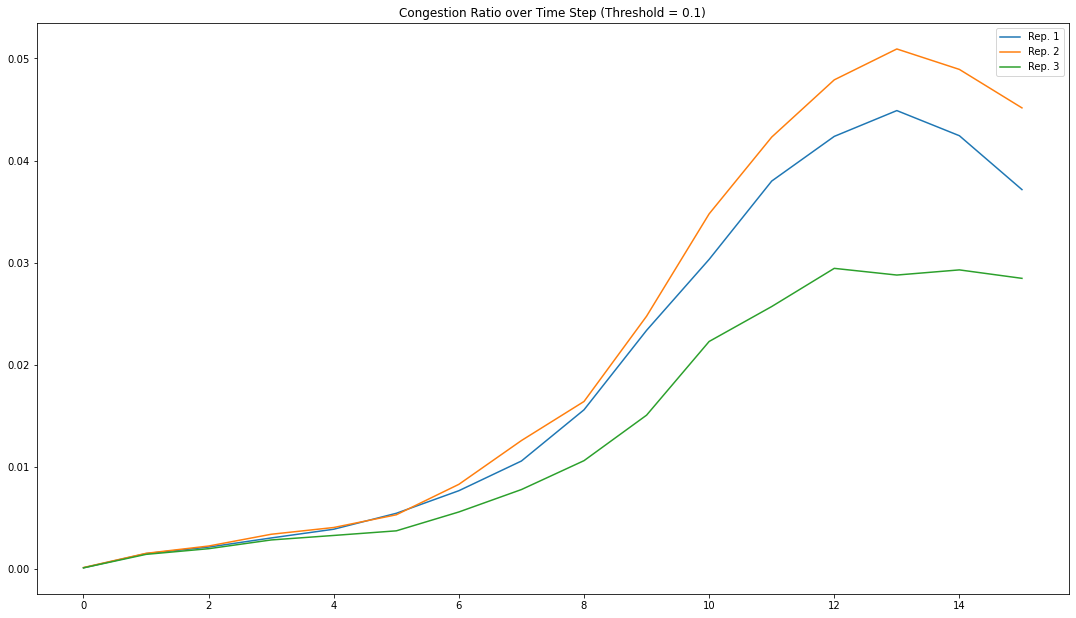

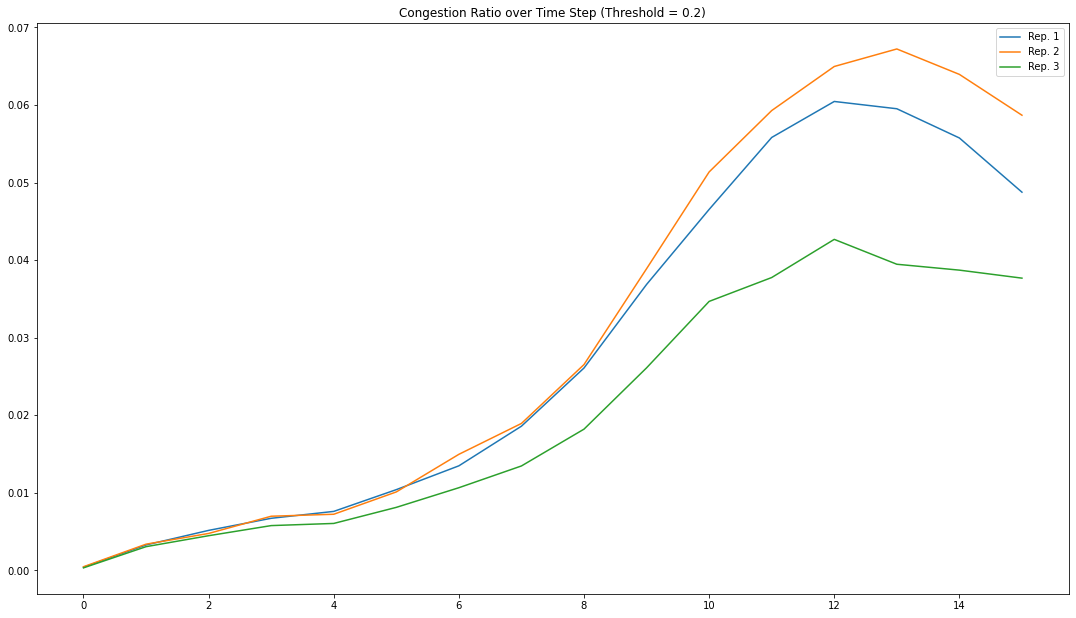

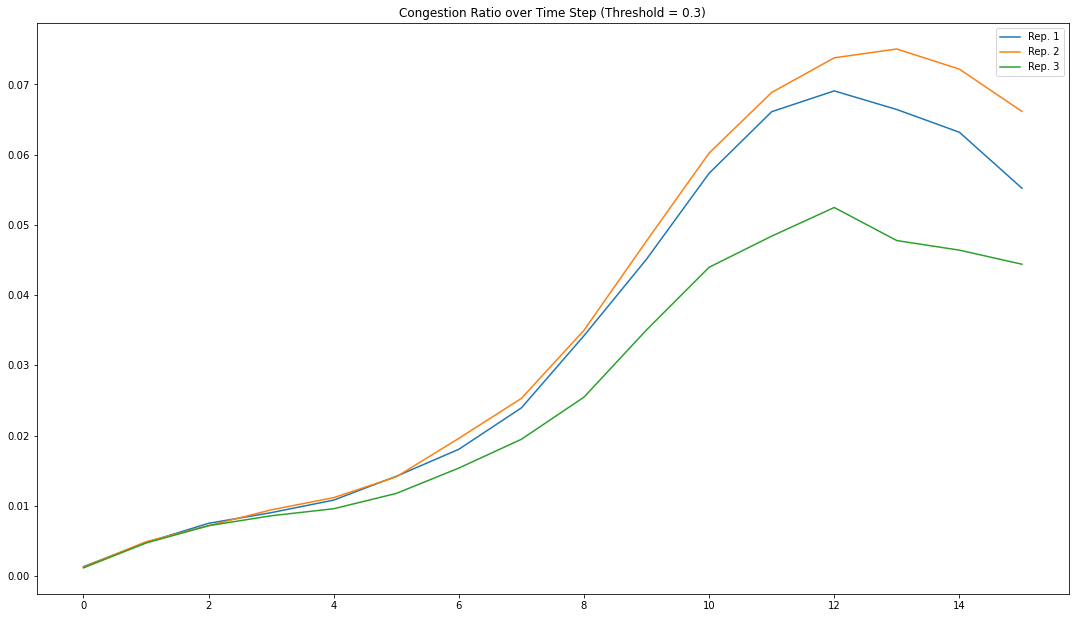

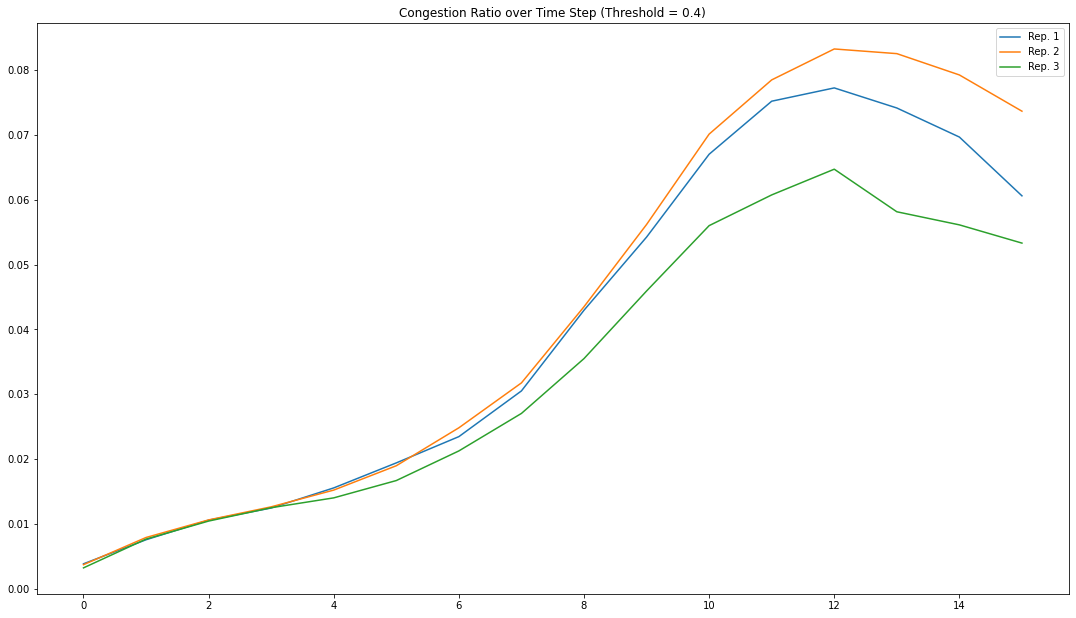

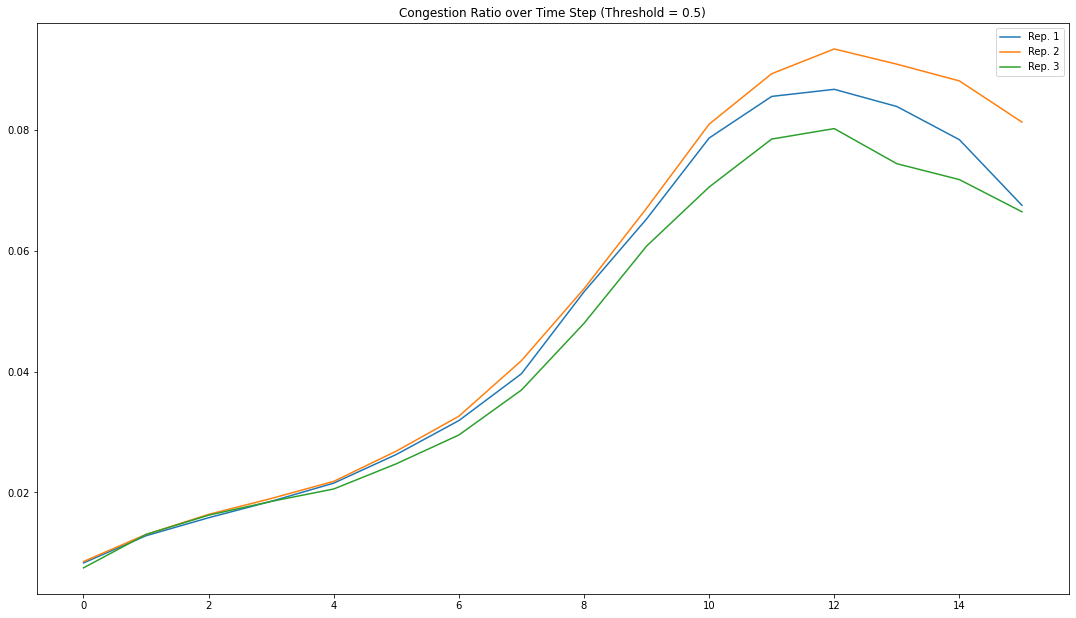

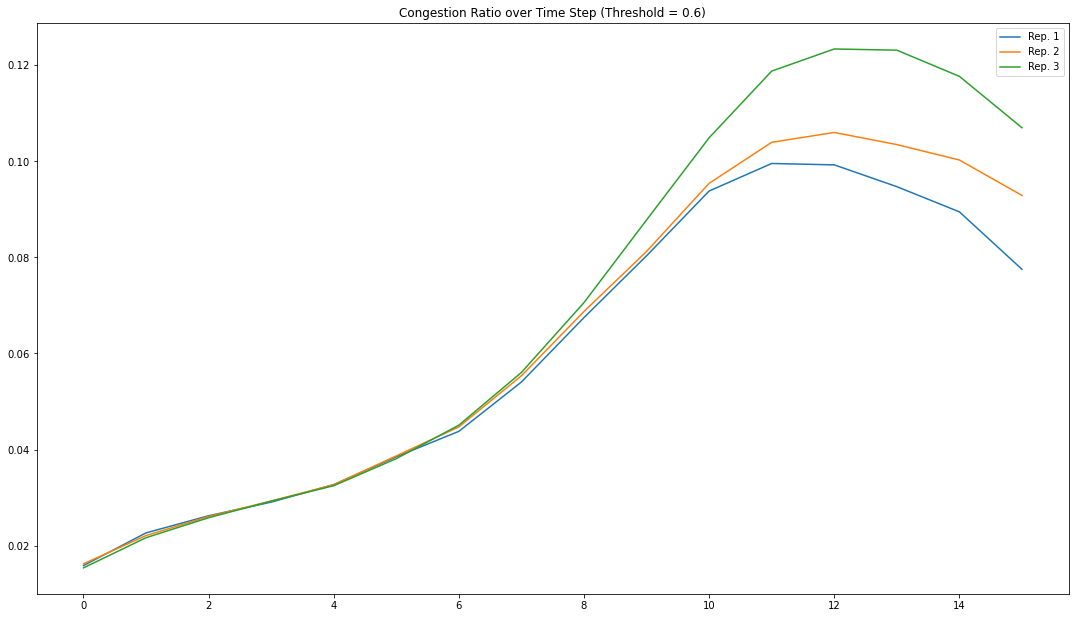

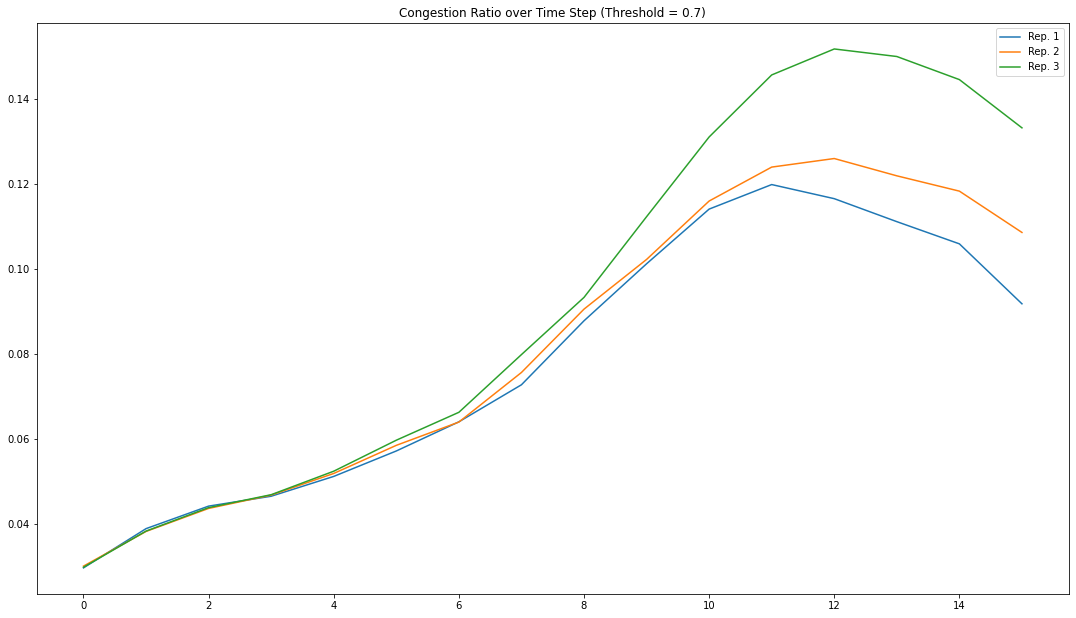

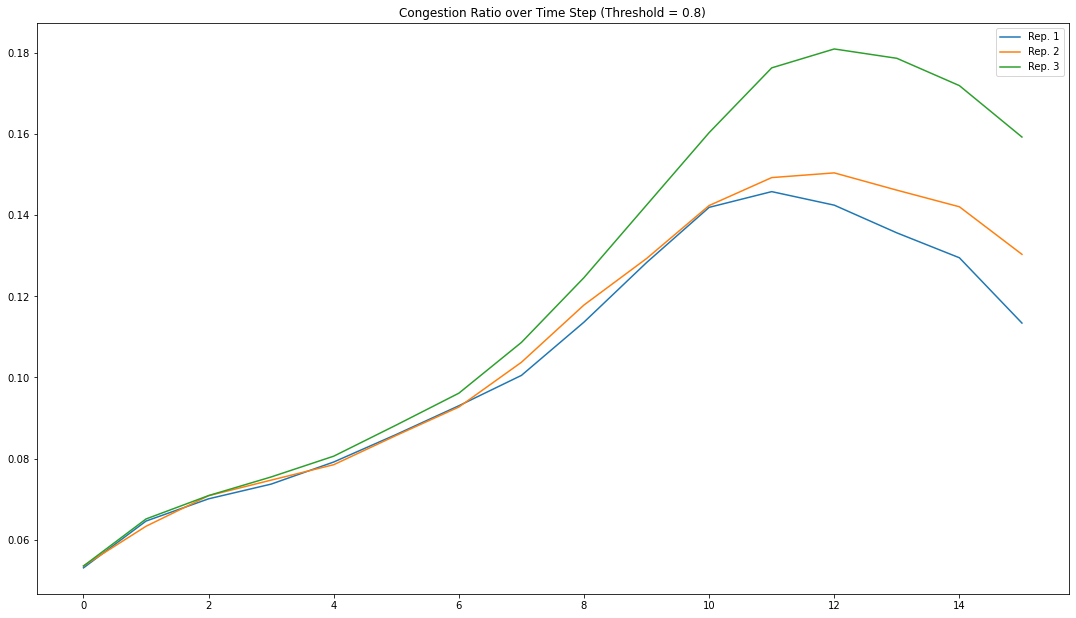

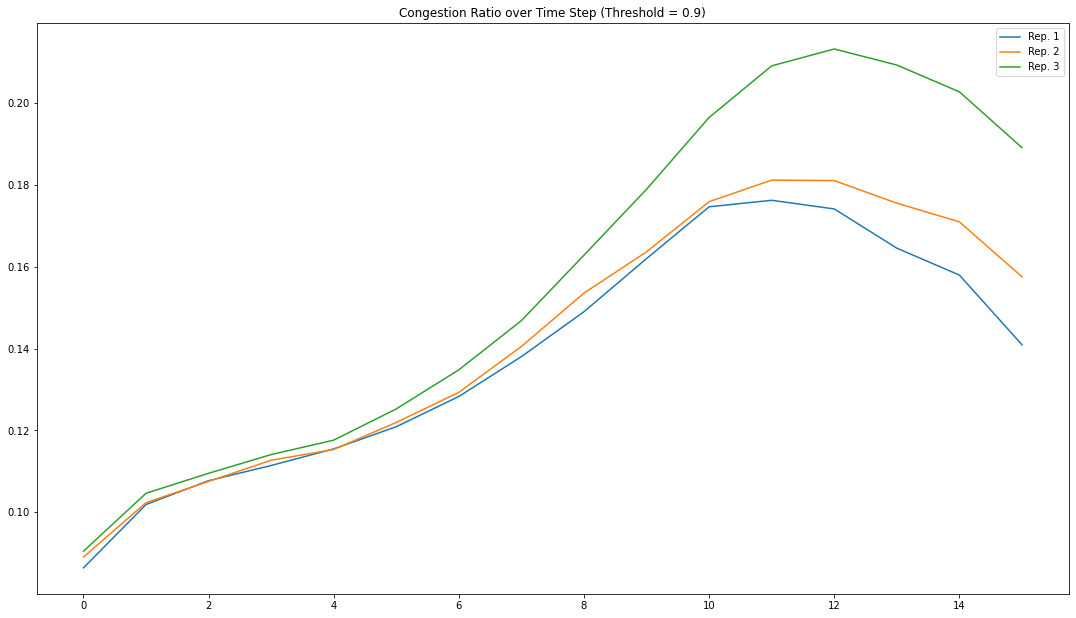

In [74]:
# Plot the aggregated(mean) flow-capacity ratio at each timestep for each experiment on Mission Boulevard
for threshold in rho:
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plot_experiment(gdf_agg, 'congestion ratio at rho = ' + str(round(threshold, 1)))

    plt.legend(["Rep. 1",
                "Rep. 2",
                "Rep. 3"
               ])
    plt.title('Congestion Ratio over Time Step (Threshold = {threshold})'.format(threshold=str(round(threshold, 1))))
    plt.show()

In [75]:
gdf_congested_count_agg[0].head(10)

,speed,speed_limit,length,congested at rho = 0.1,congested at rho = 0.2,congested at rho = 0.3,congested at rho = 0.4,congested at rho = 0.5,congested at rho = 0.6,congested at rho = 0.7,...,congested at rho = 0.9,weight at rho = 0.1,weight at rho = 0.2,weight at rho = 0.3,weight at rho = 0.4,weight at rho = 0.5,weight at rho = 0.6,weight at rho = 0.7,weight at rho = 0.8,weight at rho = 0.9
ent,,,,,,,,,,,,,,,,,,,,,
1,2.072741e+06,2062250.0,1.078972e+07,14,52,139,342,674,1140,1874,...,4158,1875.725479,5498.323511,17951.439904,52020.145548,112416.071366,2.141074e+05,4.009002e+05,7.164890e+05,1.166945e+06
2,2.126516e+06,2142800.0,1.147241e+07,81,177,279,503,875,1446,2300,...,4833,20664.190798,44321.036301,64232.538172,102144.002090,173225.233394,3.060162e+05,5.254690e+05,8.724102e+05,1.376240e+06
3,2.128133e+06,2164540.0,1.167376e+07,124,254,418,643,1019,1631,2551,...,5069,29258.430193,69686.760942,101302.333995,142990.018172,213416.855891,3.542095e+05,5.969741e+05,9.465111e+05,1.455066e+06
4,2.125287e+06,2174280.0,1.175464e+07,147,321,489,749,1162,1783,2696,...,5263,41326.801710,90736.429506,121765.067372,168285.995012,250135.034886,3.924670e+05,6.283476e+05,9.955258e+05,1.505165e+06
5,2.122168e+06,2184230.0,1.188104e+07,182,366,574,878,1296,1948,2913,...,5449,52877.949695,102735.329065,145968.754671,210156.289978,290846.523772,4.419514e+05,6.913031e+05,1.069179e+06,1.560053e+06
6,2.109536e+06,2190920.0,1.197606e+07,269,517,739,1045,1507,2215,3168,...,5689,73937.881165,140636.498972,191777.410782,262300.871101,354898.946912,5.200023e+05,7.720932e+05,1.160927e+06,1.633268e+06
7,2.093120e+06,2191890.0,1.200322e+07,358,649,890,1225,1730,2390,3434,...,5973,103802.323652,182109.941198,243781.233308,317017.376179,430679.966807,5.916294e+05,8.646669e+05,1.256609e+06,1.733229e+06
8,2.067678e+06,2192330.0,1.206812e+07,499,859,1137,1543,2075,2857,3853,...,6368,143068.662422,251142.675456,323450.556426,412281.349396,535373.075216,7.303795e+05,9.822736e+05,1.357726e+06,1.864885e+06
9,2.032824e+06,2192060.0,1.214375e+07,742,1213,1610,2036,2606,3401,4438,...,6871,210766.389265,352451.387258,462274.884003,580397.748442,718510.038306,9.115620e+05,1.185441e+06,1.535186e+06,2.013272e+06


## CSV Processing

In [12]:
csv_dict = {}
for hour in __CSV_HOUR:
    csv_list = []
    precentages = __CSV_1_PERCENT if hour == 1 else __CSV_4_PERCENT
    for percent in precentages:
        csv_list.append(pd.read_csv(__CSV_PATH_FORMAT.format(hour=hour, percent=percent)))
    csv_dict[hour] = csv_list

/var/folders/r7/9n0s_9zn64zcslbn8gzj_8xc0000gn/T/ipykernel_92208/4261911053.py:6: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_list.append(pd.read_csv(__CSV_PATH_FORMAT.format(hour=hour, percent=percent)))


In [89]:
csv_1_100 = csv_dict[1][1]

In [15]:
csv_1_100

,Id,Length,SpeedLimit,Y_f,X_f,Y_t,X_t,V1,V2,V3,...,S23,S24,S25,S26,S27,S28,S29,S30,S31,S32
0,5012,2572,90,145.004384,-38.472546,144.977267,-38.481716,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,5016,3153,90,144.941462,-38.477830,144.977267,-38.481716,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,5005,3822,90,144.904157,-38.459777,144.941462,-38.477830,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,5018,3153,90,144.977267,-38.481716,144.941462,-38.477830,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,5007,1376,90,145.021315,-38.461851,145.018962,-38.474111,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34355,19764,163,60,144.978379,-37.442249,144.979117,-37.443622,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
34356,19762,199,60,144.978812,-37.444062,144.978379,-37.442249,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
34357,19285,222,100,144.981184,-37.440141,144.981576,-37.442123,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
34358,19283,261,100,144.980941,-37.444339,144.981004,-37.441987,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


## SIR Model

In [76]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [79]:
def plot_SIR(N=34918, I0=1, beta=0.2, gamma=0.1, k=2.12):
    # Total population, N.
#     N = 1000
    # Initial number of infected and recovered individuals, I0 and R0.
#     I0 = 1
    R0 = 0
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    # beta, gamma = 0.2, 1./10 
    # A grid of time points (in minutes)
    t = np.linspace(0, 240, 240)

    # The SIR model differential equations. SIR-FCR
    def deriv(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / N * k
        dIdt = beta * S * I / N * k - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T

    # Plot the data on three separate curves for S(t), I(t) and R(t)
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.semilogy(t, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.semilogy(t, I/N, 'r', alpha=0.5, lw=2, label='Infected')
    ax.semilogy(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.set_xlabel('Time /mins')
    ax.set_ylabel('Log Percentage')
#     ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(visible=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

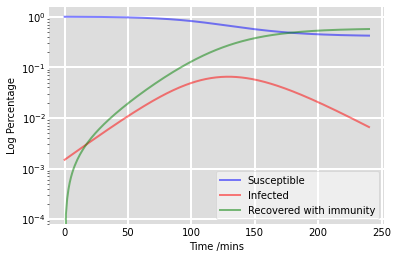

In [80]:
plot_SIR(I0=52, beta=0.0577, gamma=0.0812)